# Application of SGP model to the Wind-Tunnel dataset

<div class="jumbotron text-left"><b>
The French Aerospace Lab ONERA <br/>
Information Processing and Systems Department (DTIS) <br/>
Multidisciplinary Methods, Integrated Concepts (M2CI) Research Unit <br/>
</div>
    
**Latest update:** December 2023 - Hugo Valayer

## 0- Import librairies

In [117]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans
import warnings
warnings.filterwarnings('ignore')

# Database API libraries
import sqlite3
import pandas as pd

# Sparse GP regression model
from smt.surrogate_models import SGP

In [118]:
# Import GPy for comparison
run_GPy = False
try:
    import GPy
except ModuleNotFoundError:
    print("GPy module not found.")
else:
    run_GPy = True
    print("GPy version:", GPy.__version__)
finally:
    print("Run GPy tests:", run_GPy)

GPy module not found.
Run GPy tests: False


## I- Declare useful functions and settings

In [119]:
# Set seed
np.random.seed(0)

In [120]:
# pairplot of inducing points Z over training set
def pairplot_Z(X_train, Z, savename):

    fig, axs = plt.subplots(2, 3, figsize=(16, 10))

    axs[0,0].plot(X_train[:,0], X_train[:,1], '.', label="Training inputs")
    axs[0,0].plot(Z[:,0], Z[:,1], 'o', label="Inducing inputs")
    axs[0,0].set_xlabel('M0C'); axs[0,0].set_ylabel('RE0C')

    axs[0,1].plot(X_train[:,0], X_train[:,2], '.', label="Training inputs")
    axs[0,1].plot(Z[:,0], Z[:,2], 'o', label="Inducing inputs")
    axs[0,1].set_xlabel('M0C'); axs[0,1].set_ylabel('ALPHAC')

    axs[0,2].plot(X_train[:,0], X_train[:,3], '.', label="Training inputs")
    axs[0,2].plot(Z[:,0], Z[:,3], 'o', label="Inducing inputs")
    axs[0,2].set_xlabel('M0C'); axs[0,2].set_ylabel('BETA')

    axs[1,0].plot(X_train[:,1], X_train[:,2], '.', label="Training inputs")
    axs[1,0].plot(Z[:,1], Z[:,2], 'o', label="Inducing inputs")
    axs[1,0].set_xlabel('RE0C'); axs[1,0].set_ylabel('ALPHAC')

    axs[1,1].plot(X_train[:,1], X_train[:,3], '.', label="Training inputs")
    axs[1,1].plot(Z[:,1], Z[:,3], 'o', label="Inducing inputs")
    axs[1,1].set_xlabel('RE0C'); axs[1,1].set_ylabel('BETA')

    axs[1,2].plot(X_train[:,2], X_train[:,3], '.', label="Training inputs")
    axs[1,2].plot(Z[:,2], Z[:,3], 'o', label="Inducing inputs")
    axs[1,2].set_xlabel('ALPHA'); axs[1,2].set_ylabel('BETA')

    axs[0,2].legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [121]:
# pairplot of inducing points Z1, Z2 over training set
def pairplot_Z1_Z2(X_train, Z1, Z2, savename):

    fig, axs = plt.subplots(2, 3, figsize=(16, 10))

    axs[0,0].plot(X_train[:,0], X_train[:,1], '.', label="Training inputs")
    axs[0,0].plot(Z1[:,0], Z1[:,1], 'o', label="Random Inducing inputs")
    axs[0,0].plot(Z2[:,0], Z2[:,1], 'd', label="k-means Inducing inputs")
    axs[0,0].set_xlabel('M0C'); axs[0,0].set_ylabel('RE0C')

    axs[0,1].plot(X_train[:,0], X_train[:,2], '.', label="Training inputs")
    axs[0,1].plot(Z1[:,0], Z1[:,2], 'o', label="Random Inducing inputs")
    axs[0,1].plot(Z2[:,0], Z2[:,2], 'd', label="k-means Inducing inputs")
    axs[0,1].set_xlabel('M0C'); axs[0,1].set_ylabel('ALPHAC')

    axs[0,2].plot(X_train[:,0], X_train[:,3], '.', label="Training inputs")
    axs[0,2].plot(Z1[:,0], Z1[:,3], 'o', label="Random Inducing inputs")
    axs[0,2].plot(Z2[:,0], Z2[:,3], 'd', label="k-means Inducing inputs")
    axs[0,2].set_xlabel('M0C'); axs[0,2].set_ylabel('BETA')

    axs[1,0].plot(X_train[:,1], X_train[:,2], '.', label="Training inputs")
    axs[1,0].plot(Z1[:,1], Z1[:,2], 'o', label="Random Inducing inputs")
    axs[1,0].plot(Z2[:,1], Z2[:,2], 'd', label="k-means Inducing inputs")
    axs[1,0].set_xlabel('RE0C'); axs[1,0].set_ylabel('ALPHAC')

    axs[1,1].plot(X_train[:,1], X_train[:,3], '.', label="Training inputs")
    axs[1,1].plot(Z1[:,1], Z1[:,3], 'o', label="Random Inducing inputs")
    axs[1,1].plot(Z2[:,1], Z2[:,3], 'd', label="k-means Inducing inputs")
    axs[1,1].set_xlabel('RE0C'); axs[1,1].set_ylabel('BETA')

    axs[1,2].plot(X_train[:,2], X_train[:,3], '.', label="Training inputs")
    axs[1,2].plot(Z1[:,2], Z1[:,3], 'o', label="Random Inducing inputs")
    axs[1,2].plot(Z1[:,2], Z1[:,3], 'd', label="k-means Inducing inputs")
    axs[1,2].set_xlabel('ALPHA'); axs[1,2].set_ylabel('BETA')

    axs[0,2].legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [122]:
# pairplot of inducing points Z2, Z3 over training set
def pairplot_Z2_Z3(X_train, Z2, Z3, savename):

    fig, axs = plt.subplots(2, 3, figsize=(16, 10))

    axs[0,0].plot(X_train[:,0], X_train[:,1], '.', label="Training inputs")
    axs[0,0].plot(Z2[:,0], Z2[:,1], 'd', c='green', label="k-means Inducing inputs")
    axs[0,0].plot(Z3[:,0], Z3[:,1], 's', c='red', label="Normalized k-means Inducing inputs")
    axs[0,0].set_xlabel('M0C'); axs[0,0].set_ylabel('RE0C')

    axs[0,1].plot(X_train[:,0], X_train[:,2], '.', label="Training inputs")
    axs[0,1].plot(Z2[:,0], Z2[:,2], 'd', c='green', label="k-means Inducing inputs")
    axs[0,1].plot(Z3[:,0], Z3[:,2], 's', c='red', label="Normalized k-means Inducing inputs")
    axs[0,1].set_xlabel('M0C'); axs[0,1].set_ylabel('ALPHAC')

    axs[0,2].plot(X_train[:,0], X_train[:,3], '.', label="Training inputs")
    axs[0,2].plot(Z2[:,0], Z2[:,3], 'd', c='green', label="k-means Inducing inputs")
    axs[0,2].plot(Z3[:,0], Z3[:,3], 's',c='red', label="Normalized k-means Inducing inputs")
    axs[0,2].set_xlabel('M0C'); axs[0,2].set_ylabel('BETA')

    axs[1,0].plot(X_train[:,1], X_train[:,2], '.', label="Training inputs")
    axs[1,0].plot(Z2[:,1], Z2[:,2], 'd', c='green', label="k-means Inducing inputs")
    axs[1,0].plot(Z3[:,1], Z3[:,2], 's', c='red', label="Normalized k-means Inducing inputs")
    axs[1,0].set_xlabel('RE0C'); axs[1,0].set_ylabel('ALPHAC')

    axs[1,1].plot(X_train[:,1], X_train[:,3], '.', label="Training inputs")
    axs[1,1].plot(Z2[:,1], Z2[:,3], 'd', c='green', label="k-means Inducing inputs")
    axs[1,1].plot(Z3[:,1], Z3[:,3], 's', c='red', label="Normalized k-means Inducing inputs")
    axs[1,1].set_xlabel('RE0C'); axs[1,1].set_ylabel('BETA')

    axs[1,2].plot(X_train[:,2], X_train[:,3], '.', label="Training inputs")
    axs[1,2].plot(Z1[:,2], Z1[:,3], 'd',c='green', label="k-means Inducing inputs")
    axs[1,2].plot(Z3[:,2], Z3[:,3], 's', c='red', label="Normalized k-means Inducing inputs")
    axs[1,2].set_xlabel('ALPHA'); axs[1,2].set_ylabel('BETA')

    axs[0,2].legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [123]:
# pairplot of inducing points Z1, Z2, Z3 over training set
def pairplot_Z_all(X_train, Z1, Z2, Z3, savename):

    fig, axs = plt.subplots(2, 3, figsize=(16, 10))

    axs[0,0].plot(X_train[:,0], X_train[:,1], '.', label="Training inputs")
    axs[0,0].plot(Z1[:,0], Z1[:,1], 'o', label="Random Inducing inputs")
    axs[0,0].plot(Z2[:,0], Z2[:,1], 'd', label="k-means Inducing inputs")
    axs[0,0].plot(Z3[:,0], Z3[:,1], 's', label="Normalized k-means Inducing inputs")
    axs[0,0].set_xlabel('M0C'); axs[0,0].set_ylabel('RE0C')

    axs[0,1].plot(X_train[:,0], X_train[:,2], '.', label="Training inputs")
    axs[0,1].plot(Z1[:,0], Z1[:,2], 'o', label="Random Inducing inputs")
    axs[0,1].plot(Z2[:,0], Z2[:,2], 'd', label="k-means Inducing inputs")
    axs[0,1].plot(Z3[:,0], Z3[:,2], 's', label="Normalized k-means Inducing inputs")
    axs[0,1].set_xlabel('M0C'); axs[0,1].set_ylabel('ALPHAC')

    axs[0,2].plot(X_train[:,0], X_train[:,3], '.', label="Training inputs")
    axs[0,2].plot(Z1[:,0], Z1[:,3], 'o', label="Random Inducing inputs")
    axs[0,2].plot(Z2[:,0], Z2[:,3], 'd', label="k-means Inducing inputs")
    axs[0,2].plot(Z3[:,0], Z3[:,3], 's', label="Normalized k-means Inducing inputs")
    axs[0,2].set_xlabel('M0C'); axs[0,2].set_ylabel('BETA')

    axs[1,0].plot(X_train[:,1], X_train[:,2], '.', label="Training inputs")
    axs[1,0].plot(Z1[:,1], Z1[:,2], 'o', label="Random Inducing inputs")
    axs[1,0].plot(Z2[:,1], Z2[:,2], 'd', label="k-means Inducing inputs")
    axs[1,0].plot(Z3[:,1], Z3[:,2], 's', label="Normalized k-means Inducing inputs")
    axs[1,0].set_xlabel('RE0C'); axs[1,0].set_ylabel('ALPHAC')

    axs[1,1].plot(X_train[:,1], X_train[:,3], '.', label="Training inputs")
    axs[1,1].plot(Z1[:,1], Z1[:,3], 'o', label="Random Inducing inputs")
    axs[1,1].plot(Z2[:,1], Z2[:,3], 'd', label="k-means Inducing inputs")
    axs[1,1].plot(Z3[:,1], Z3[:,3], 's', label="Normalized k-means Inducing inputs")
    axs[1,1].set_xlabel('RE0C'); axs[1,1].set_ylabel('BETA')

    axs[1,2].plot(X_train[:,2], X_train[:,3], '.', label="Training inputs")
    axs[1,2].plot(Z1[:,2], Z1[:,3], 'o', label="Random Inducing inputs")
    axs[1,2].plot(Z1[:,2], Z1[:,3], 'd', label="k-means Inducing inputs")
    axs[1,2].plot(Z3[:,2], Z3[:,3], 's', label="Normalized k-means Inducing inputs")
    axs[1,2].set_xlabel('ALPHA'); axs[1,2].set_ylabel('BETA')

    axs[0,2].legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [124]:
# plot of surrogate model prediction vs true data / compute rmse
def plot_res(Y_pred, Y_test, output_name, M, rmse, savename):

    ymin = np.min([Y_pred, Y_test])
    ymax = np.max([Y_pred, Y_test])

    plt.figure(figsize=(8,8))
    plt.plot([ymin, ymax], [ymin, ymax], "r--", linewidth=2)
    plt.plot(Y_test.flatten(), Y_pred.flatten(), '.')
    plt.xlabel("Observations")
    plt.ylabel("Prediction")
    plt.title("%s (M=%i) - RMSE: %.4f" %(output_name, M, rmse))
    plt.savefig(savename)
    plt.show()
    

## II- Loading WT database with SQLite

### A) Load the full raw database

In [125]:
# path to the database
database = "./database.db"

In [126]:
# connecting to the database via SQLite
sqdatabase = sqlite3.connect(database)
cursor = sqdatabase.cursor()
cursor.execute("PRAGMA foreign_keys = ON")

# defining global names
label_names = ["campaign_id", "NROT", "NLOT", "CONF"] # names of some labels 
input_names = ["M0C", "RE0C", "ALPHAC", "BETA"] # names of the inputs
output_names = ["CXC", "CYC", "CZC", "CLAAC", "CMAAC", "CNAAC"] # names of the outputs

# creating dataframe for the database
raw_df = pd.DataFrame(columns = label_names + input_names + output_names)

# extracting data from the database via cursor.execute and cursor.fetchall
for name in raw_df.columns:
    string = "SELECT " + name + " FROM data"
    cursor.execute(string)
    var_temp = cursor.fetchall()
    raw_df[name] = np.array(var_temp).flatten()
    
n = raw_df.shape[0] # number of observations
d = len(input_names) # number of design variables
nout = len(output_names) # number of outputs
nlabels = len(label_names) # number of labels

# closing the connection
sqdatabase.close()

### B) Extract subdataset as pandas.dataframe

We here consider the subdataset **df:** CONF=BWV

In [127]:
# path to folder where CONF indices files are stored
path = "./conf.npz"

# extract indices for CONF=BWV
with np.load(path, allow_pickle=True) as file:
    bwv_idx = file["idx"].item()["BWV"]

# size of subdataset
print("The reduced database (CONF=BWV) contains %i observations" %len(bwv_idx))

The reduced database (CONF=BWV) contains 52227 observations


In [128]:
df = raw_df.loc[bwv_idx]
df.head()

,campaign_id,NROT,NLOT,CONF,M0C,RE0C,ALPHAC,BETA,CXC,CYC,CZC,CLAAC,CMAAC,CNAAC
16434,1,22266,744,BWV,0.098984,3024689.25,-9.686342,0.0,0.067545,-0.001204,-0.644340,-0.003492,-0.109003,0.000248
16435,1,22266,744,BWV,0.098990,3025039.25,-9.832882,0.0,0.070860,-0.000647,-0.651361,-0.003688,-0.112178,-0.000198
16436,1,22266,744,BWV,0.098999,3025547.50,-9.517721,0.0,0.063793,-0.001400,-0.636383,-0.001913,-0.103033,0.002586
16437,1,22266,744,BWV,0.098875,3021878.75,-9.363862,0.0,0.061694,-0.000442,-0.627987,0.003453,-0.099289,-0.000132
16438,1,22266,744,BWV,0.098853,3021007.25,-9.203516,0.0,0.059104,0.002027,-0.617787,0.007657,-0.097414,-0.006095


### C) Histograms of subdataset

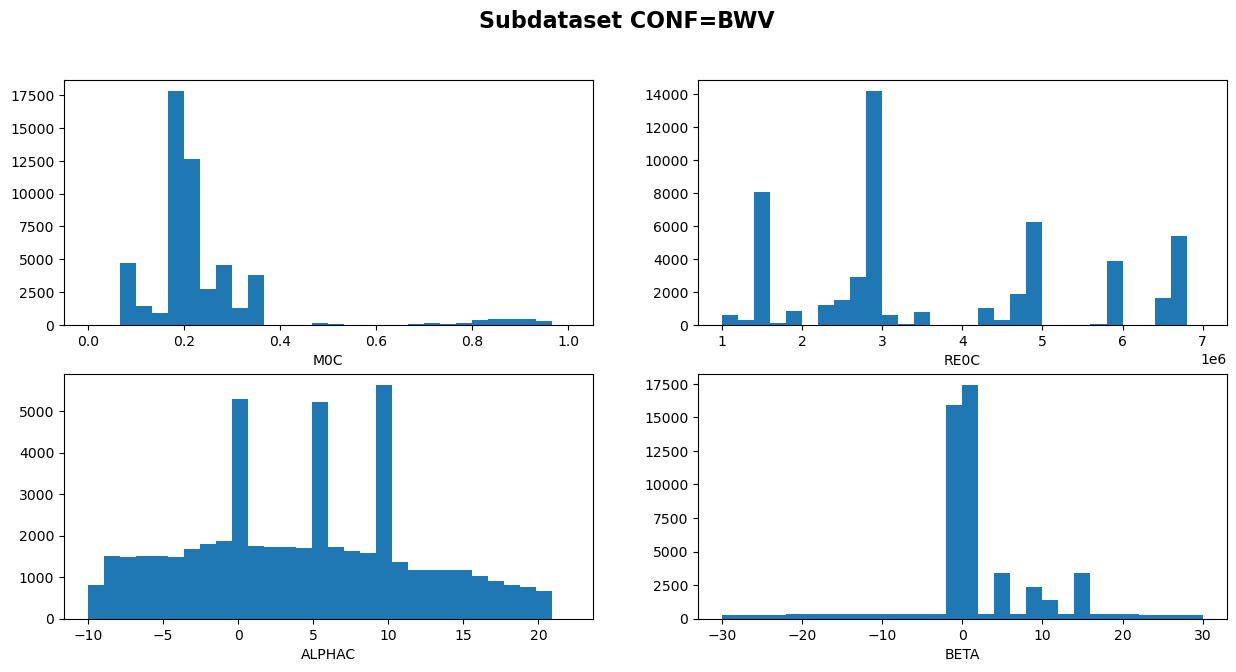

In [129]:
hist_range = {"M0C":[0.0, 1.0], "RE0C":[1e6, 7e6], "ALPHAC":[-10, 22], "BETA":[-30, 30]}
fig, axes = plt.subplots(2, 2, figsize=(15,7))
fig.suptitle("Subdataset CONF=BWV", fontsize=16, fontweight='bold')
for ax, name in zip(axes.flat, input_names):
    ax.hist(df[name], range=hist_range[name], bins=30)
    ax.set(xlabel=name)

## III- Prepare train and test data

We consider the mapping between inputs $M$, $R$, $\alpha$, $\beta$ and the ouput $C_z$.

In [130]:
print(' ------------------- Output  C_z ----------------------------------------')

 ------------------- Output  C_z ----------------------------------------


### A) Define train and test samples

In [131]:
X = np.array(df[['M0C','RE0C','ALPHAC','BETA']]); print("X shape:", X.shape)
Y = np.array(df[['CZC']]); print("Y shape:", Y.shape)
print("---"*8)
N = int(0.9*X.shape[0])
random_idx = np.random.choice(X.shape[0], N, replace=False)
X_train = X[random_idx]; print("X train shape:", X_train.shape)
Y_train = Y[random_idx]; print("Y train shape:", Y_train.shape)
X_test = np.delete(X, random_idx, axis=0); print("X test  shape:", X_test.shape)
Y_test = np.delete(Y, random_idx, axis=0); print("Y test  shape:", Y_test.shape)

X shape: (52227, 4)
Y shape: (52227, 1)
------------------------
X train shape: (47004, 4)
Y train shape: (47004, 1)
X test  shape: (5223, 4)
Y test  shape: (5223, 1)


### B) Define inducing inputs

In [132]:
M = 50

#### 1. Random selection among dataset

In [133]:
# Perform random permutation
shuffle_idx = np.random.permutation(X_train.shape[0])[:M]
Z1 = X_train[shuffle_idx].copy()

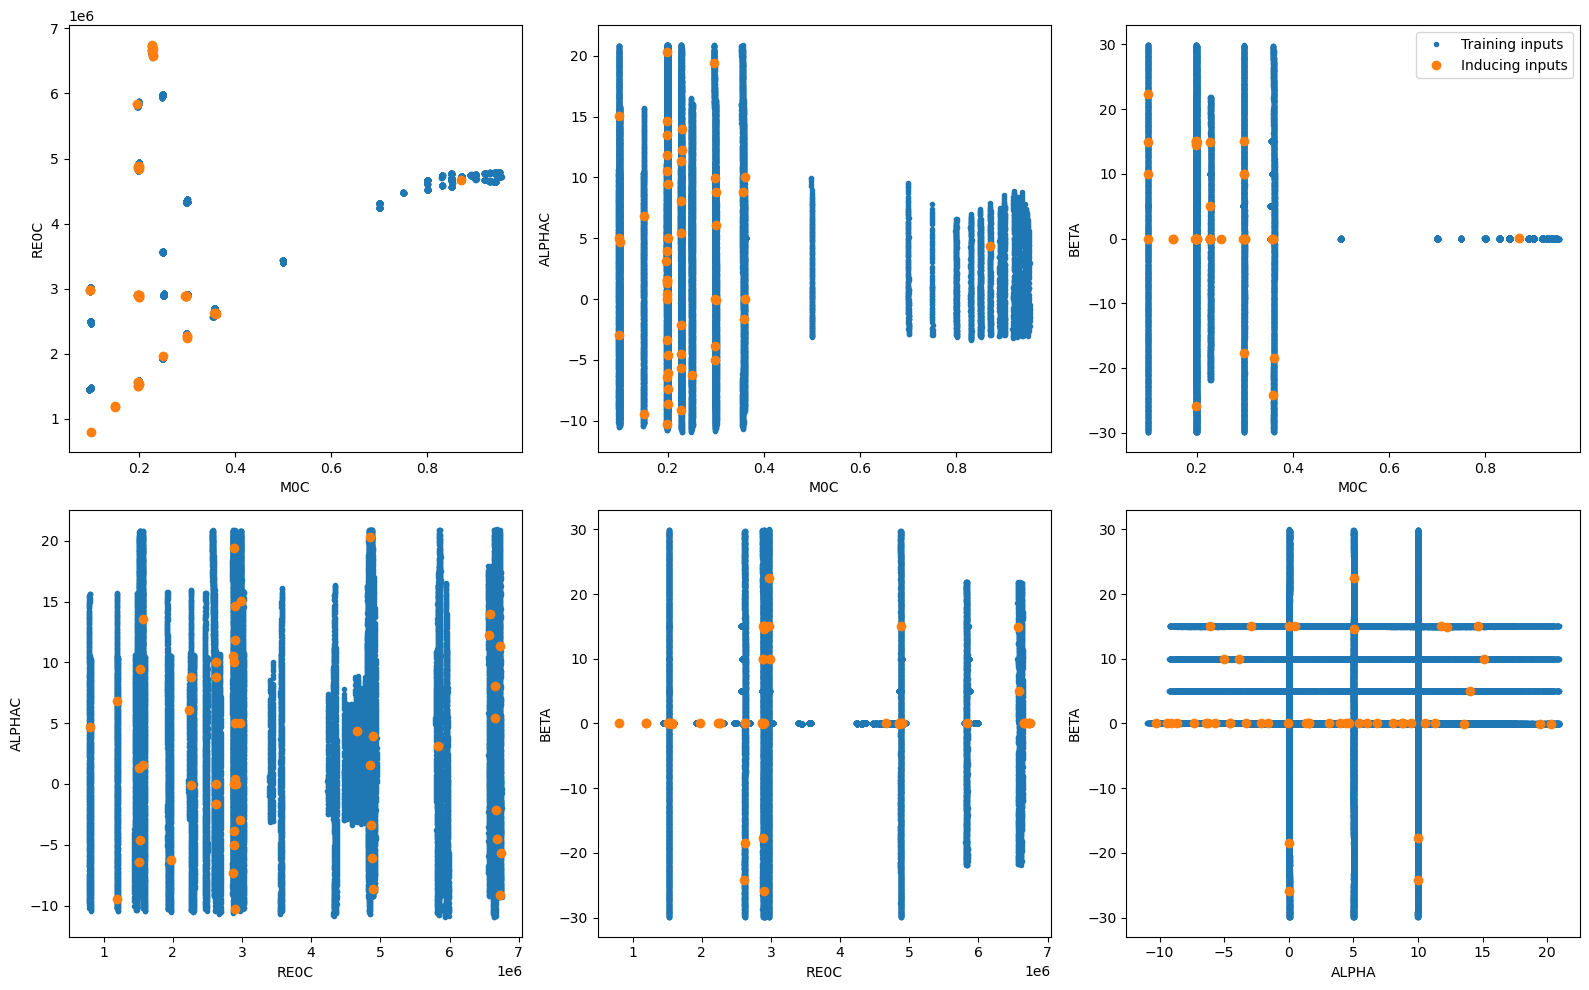

In [134]:
# Plot training data along with inducing points (subplots for pairs of dimensions)
savename = "FIG_WT/CZ_pairplot_M50_random.png"
pairplot_Z(X_train, Z1, savename)

#### 2. Using k-means selection

In [135]:
# Define inducing inputs as centroids of k-means clusters over (X,Y)
data = np.hstack((X_train, Y_train))

# Perform k-means
start = time.time()
Z2 = kmeans(data, M)[0][:,:-1]
elapsed = time.time() - start
print("k-means computation time: %.2fs" %elapsed)

k-means computation time: 48.81s


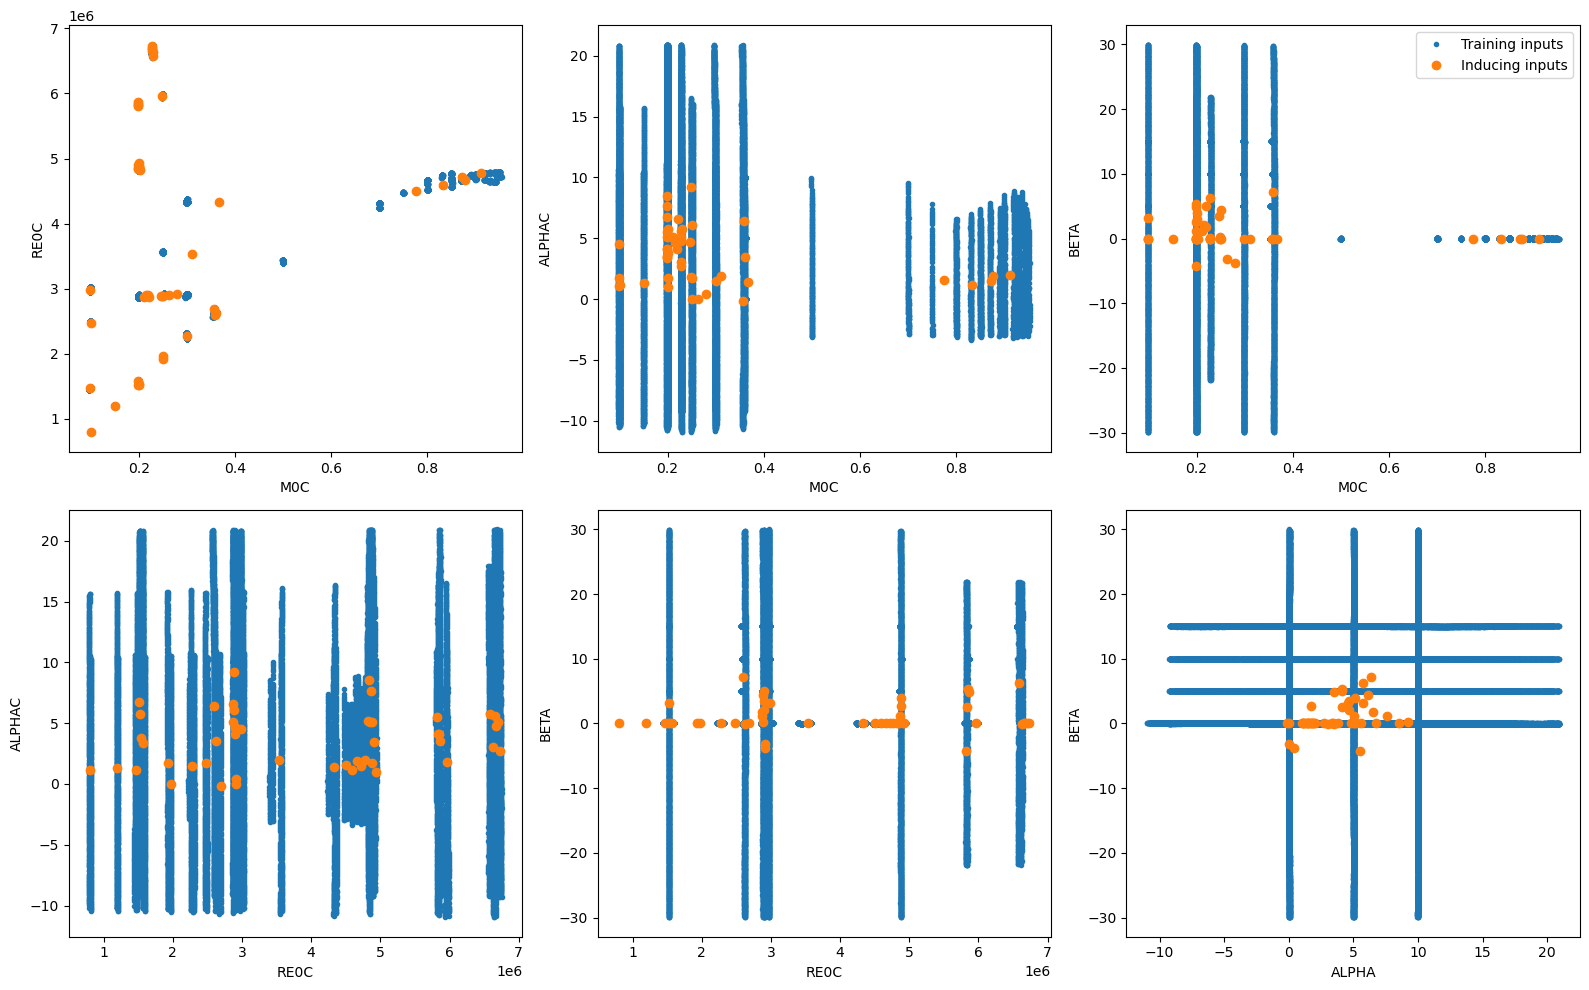

In [136]:
# Plot training data along with inducing points (subplots for pairs of dimensions)
savename = "FIG_WT/CZ_pairplot_M50_kmeans.png"
pairplot_Z(X_train, Z2, savename)

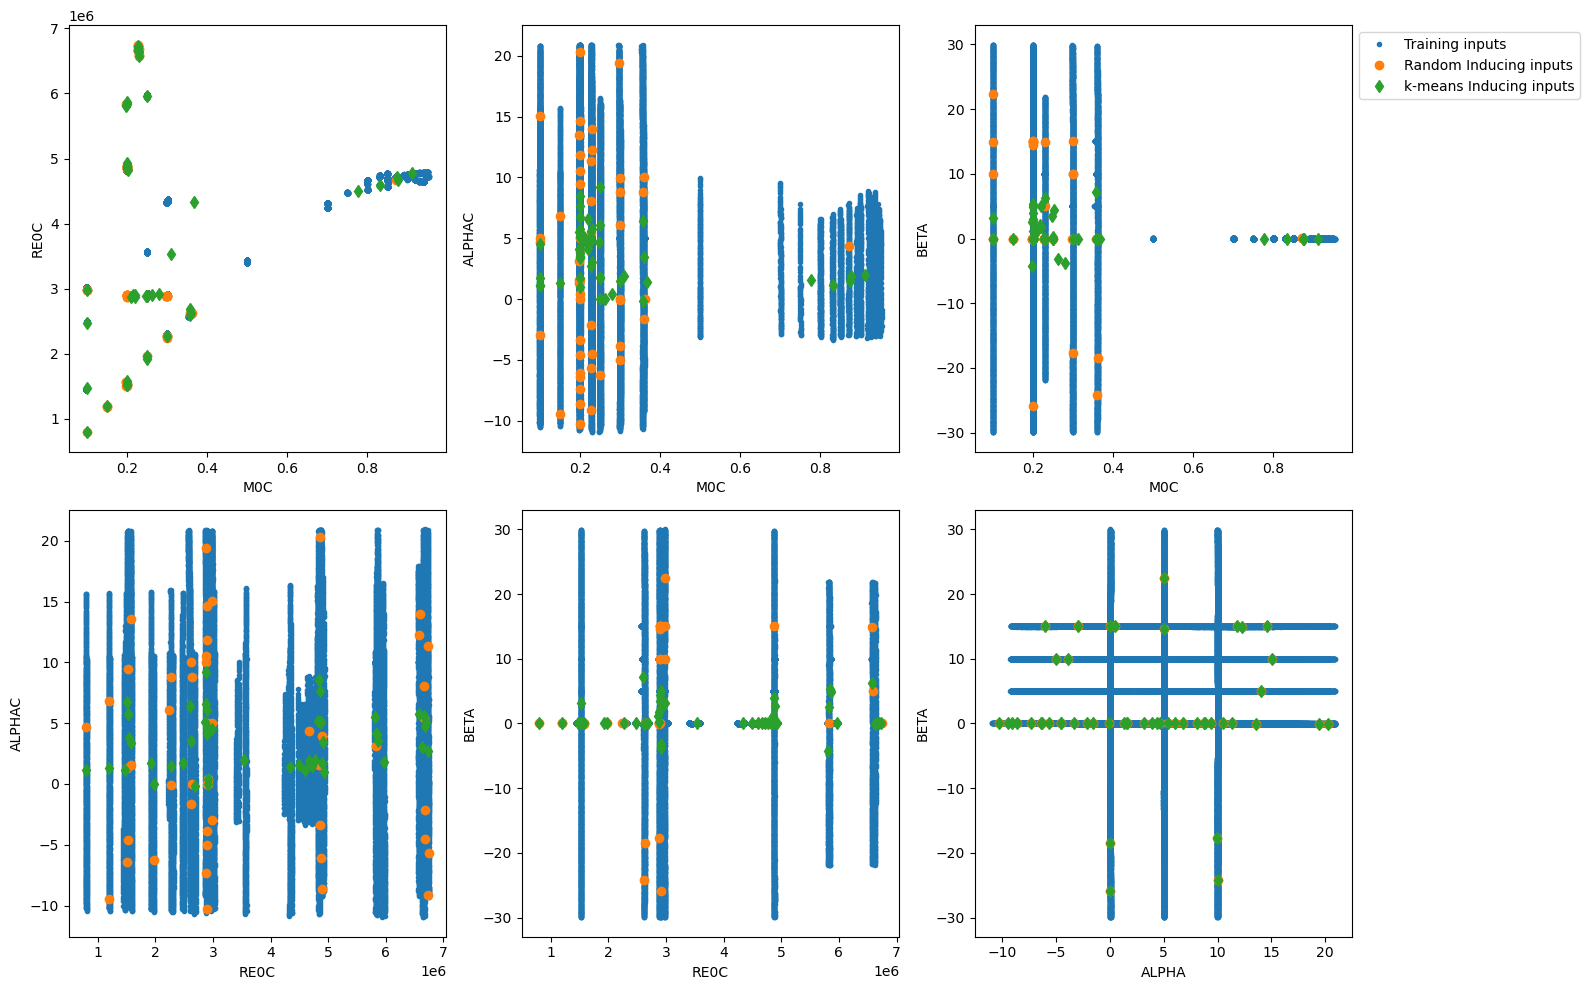

In [137]:
#to compare random and kmeans
savename = "FIG_WT/CZ_pairplot_M50_random_kmeans.png"
pairplot_Z1_Z2(X_train, Z1, Z2, savename)

## IV- Train the SGP model

### 0) GPy version

In [138]:
l0 = np.std(X_train, axis=0)
print(l0)

[1.49646808e-01 1.75404478e+06 7.47649346e+00 8.50650260e+00]


In [139]:
if run_GPy:

    k = GPy.kern.RBF(input_dim=4, lengthscale=l0, ARD=True) # custom initialization of kernel lenghtscale
    sm = GPy.models.SparseGPRegression(X=X_train, Y=Y_train, kernel=k, Z=Z1)
    sm.inference_method = GPy.inference.latent_function_inference.FITC() # FITC method
    sm.Z.fix() # avoid inducing inputs optimization
    sm.optimize('simplex', messages=1, max_iters=300) # simplex algorithm to match with Cobyla

    # Note: for light version of GPy (gpl), use following code instead:
    #k = gpl.RBF(input_dim=4, ARD=True)
    #sm = gpl.SparseGP(X=X_train, Y=Y_train, kernel=k, Z=Z1, inference_method="FITC")
    #sm.Z.fix()
    #sm.kern.lengthscale = l0
    #sm.optimize('simplex', messages=1, max_iters=300)

    # print hyperparameters optimal values
    hyperparameters = [sm.kern.variance, sm.kern.lengthscale, sm.likelihood.variance]
    print("sigma2 :", sm.kern.variance[0])
    print("length :", sm.kern.lengthscale.values)
    print("theta  :", 1/sm.kern.lengthscale**2)
    print("noise  :", sm.likelihood.variance[0])

    # prediction on test set
    Y_pred, _ = sm.predict(X_test)
    rmse = np.sqrt(np.mean((Y_pred.flatten() - Y_test.flatten())**2))
    print("RMSE = %2.4f" %rmse)

    # plot results
    plot_res(Y_pred, Y_test, "CZC", M, rmse)

### A) SMT - FITC method

In order to ensure the proper convergence of optimization, we take an initial guess for theta based on the data std.\
Also, it can be useful to change the allowed bounds for this parameter.

<div class="alert alert-block alert-danger"><b>WARNING:</b> optimization with FITC method can be quite long. </div>

In [140]:
# Initial guess for lengthscale parameter: standard deviation of training data
l = np.std(X_train, axis=0)

# Transform to theta parameter (inverse of lengthscale)
theta = 1/l**2
print("theta0 :", theta)

# Specify bounds for theta
bounds = [1e-16, 1.] 

theta0 : [4.46544850e+01 3.25026406e-13 1.78897423e-02 1.38196779e-02]


#### 1. Random inducing inputs

In [141]:
# Define model
sm = SGP(method="FITC", theta0=theta, theta_bounds=bounds, print_prediction=False, n_start=1)

# Assign training data and inducing inputs
sm.set_training_values(X_train, Y_train)
sm.set_inducing_inputs(Z=Z1)

In [142]:
# Optimize
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 47004
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 44.5525682


In [143]:
# Print hyperparameters optimal values
print("sigma2 :", sm.optimal_par["sigma2"])
print("theta  :", sm.optimal_theta)
print("noise  :", sm.optimal_noise)

sigma2 : 0.026579989127326134
theta  : [3.28145071e-01 2.19790652e-14 8.03302865e-03 7.15266130e-04]
noise  : 0.0004993931175322443


In [144]:
# Prediction on test set
Y_pred = sm.predict_values(X_test)
rmse = np.sqrt(np.mean((Y_pred.flatten() - Y_test.flatten())**2))
print("RMSE = %2.4f" %rmse)

RMSE = 0.0234


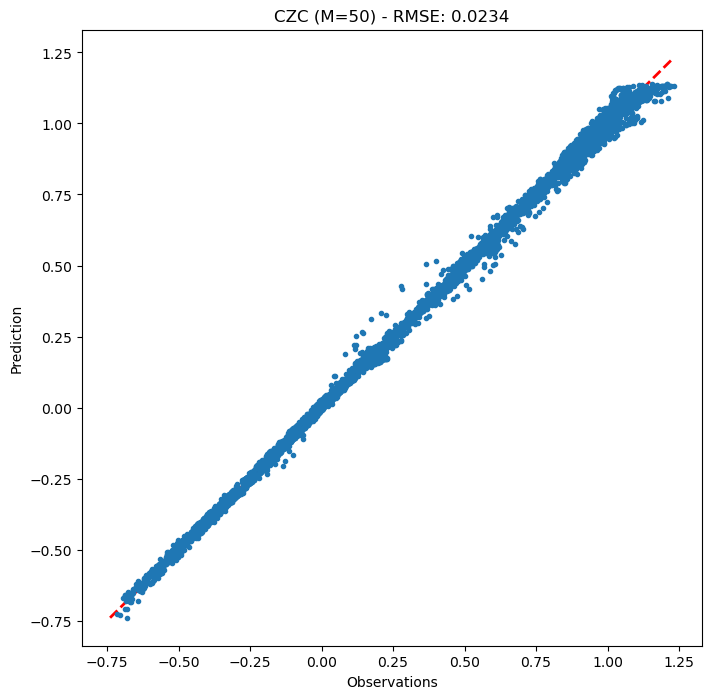

In [145]:
# Plot results
savename="FIG_WT/CZC_M50_random_FITC.png"
plot_res(Y_pred, Y_test, "CZC", M, rmse, savename)

#### 2. K-means inducing inputs

In [146]:
sm = SGP(method="FITC", theta0=theta, theta_bounds=bounds, print_prediction=False, n_start=1)
sm.set_training_values(X_train, Y_train)
sm.set_inducing_inputs(Z=Z2)
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 47004
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 40.6114089


In [147]:
print("sigma2 :", sm.optimal_par["sigma2"])
print("theta  :", sm.optimal_theta)
print("noise  :", sm.optimal_noise)

sigma2 : 0.027667288368052618
theta  : [1.69813165e-01 3.50373168e-14 3.33499871e-03 9.88494560e-04]
noise  : 0.0007934117530186106


In [148]:
Y_pred = sm.predict_values(X_test)
rmse = np.sqrt(np.mean((Y_pred.flatten() - Y_test.flatten())**2))
print("RMSE = %2.4f" %rmse)

RMSE = 0.0303


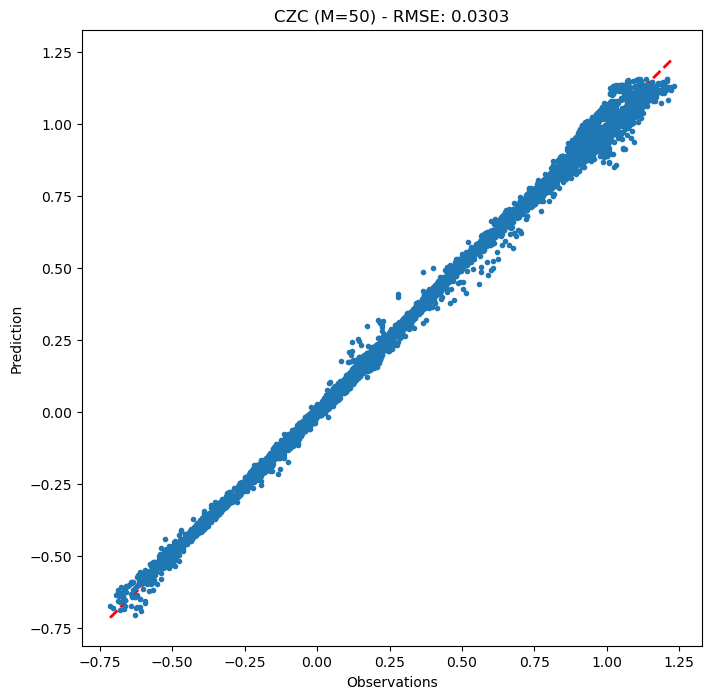

In [149]:
savename="FIG_WT/CZC_M50_kmeans_FITC.png"
plot_res(Y_pred, Y_test, "CZC", M, rmse, savename)

### B) SMT - VFE method

#### 1. Random inducing inputs

In [150]:
sm = SGP(method="VFE", theta0=theta, theta_bounds=bounds, print_prediction=False, n_start=1)
sm.set_training_values(X_train, Y_train)
sm.set_inducing_inputs(Z=Z1)
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 47004
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 38.9589164


In [151]:
print("sigma2 :", sm.optimal_par["sigma2"])
print("sigma2  :", sm.optimal_sigma2)
print("theta  :", sm.optimal_theta)
print("noise  :", sm.optimal_noise)

sigma2 : 0.006648467382068043
sigma2  : 0.006648467382068043
theta  : [1.33297650e-01 1.29026190e-14 7.59304089e-03 7.33086008e-04]
noise  : 0.0005850140378839948


In [152]:
Y_pred = sm.predict_values(X_test)
rmse = np.sqrt(np.mean((Y_pred.flatten() - Y_test.flatten())**2))
print("RMSE = %2.4f" %rmse)

RMSE = 0.0231


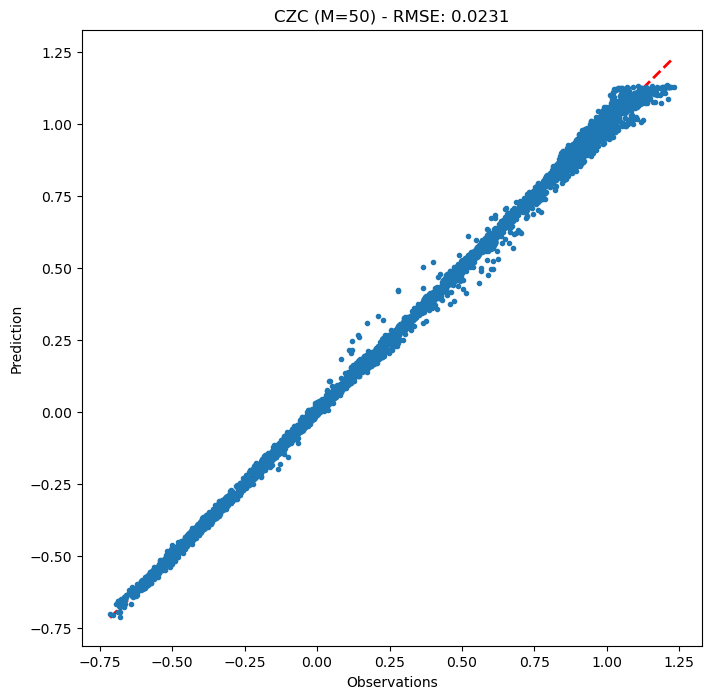

In [153]:
savename="FIG_WT/CZC_M50_random_VFE.png"
plot_res(Y_pred, Y_test, "CZC", M, rmse, savename)

#### 2. K-means inducing inputs

In [154]:
sm = SGP(method="VFE", theta0=theta, theta_bounds=bounds, print_prediction=False, n_start=1)
sm.set_training_values(X_train, Y_train)
sm.set_inducing_inputs(Z=Z2)
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 47004
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 38.9645758


In [155]:
print("sigma2 :", sm.optimal_par["sigma2"])
print("theta  :", sm.optimal_theta)
print("noise  :", sm.optimal_noise)

sigma2 : 0.059263703434351625
theta  : [9.12511023e-02 4.56633057e-14 1.23229869e-03 1.52425833e-04]
noise  : 0.0010303741552094821


In [156]:
Y_pred = sm.predict_values(X_test)
rmse = np.sqrt(np.mean((Y_pred.flatten() - Y_test.flatten())**2))
print("RMSE = %2.4f" %rmse)

RMSE = 0.0309


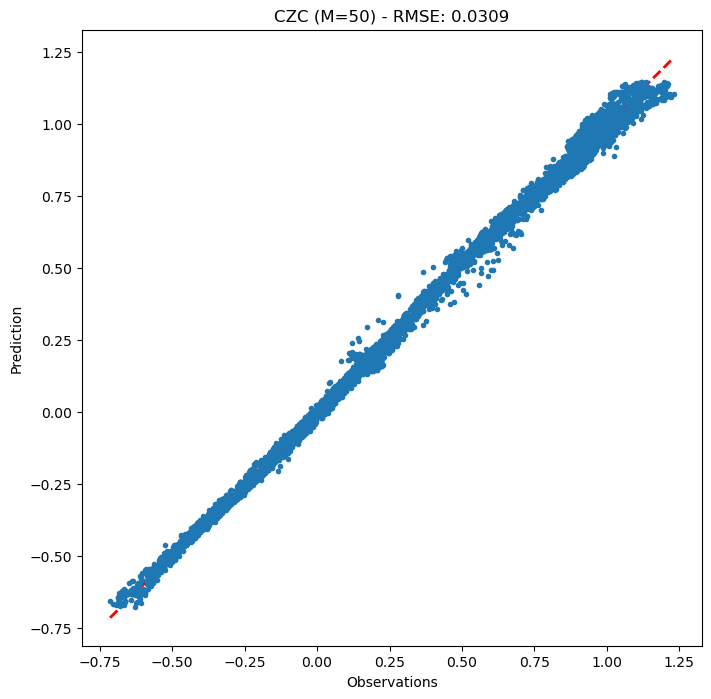

In [157]:
savename="FIG_WT/CZC_M50_kmeans_VFE.png"
plot_res(Y_pred, Y_test, "CZC", M, rmse, savename)

## V- Fit SGP model for the other scalar outputs

We now focus on the ouputs $C_x$ and $C_M$. We use the VFE method with random selection of inducing inputs among the dataset.

### A) CXC output

#### 1. Define train and test samples

In [158]:
print(' ------------------- Output  C_x ----------------------------------------')

 ------------------- Output  C_x ----------------------------------------


In [159]:
CXC = np.array(df[['CXC']])
CXC_train = CXC[random_idx]
CXC_test = np.delete(CXC, random_idx, axis=0)

#### 2. Define inducing inputs

In [160]:
M = 50

In [161]:
shuffle_idx = np.random.permutation(X_train.shape[0])[:M]
Z = X_train[shuffle_idx].copy()
Z1 = Z

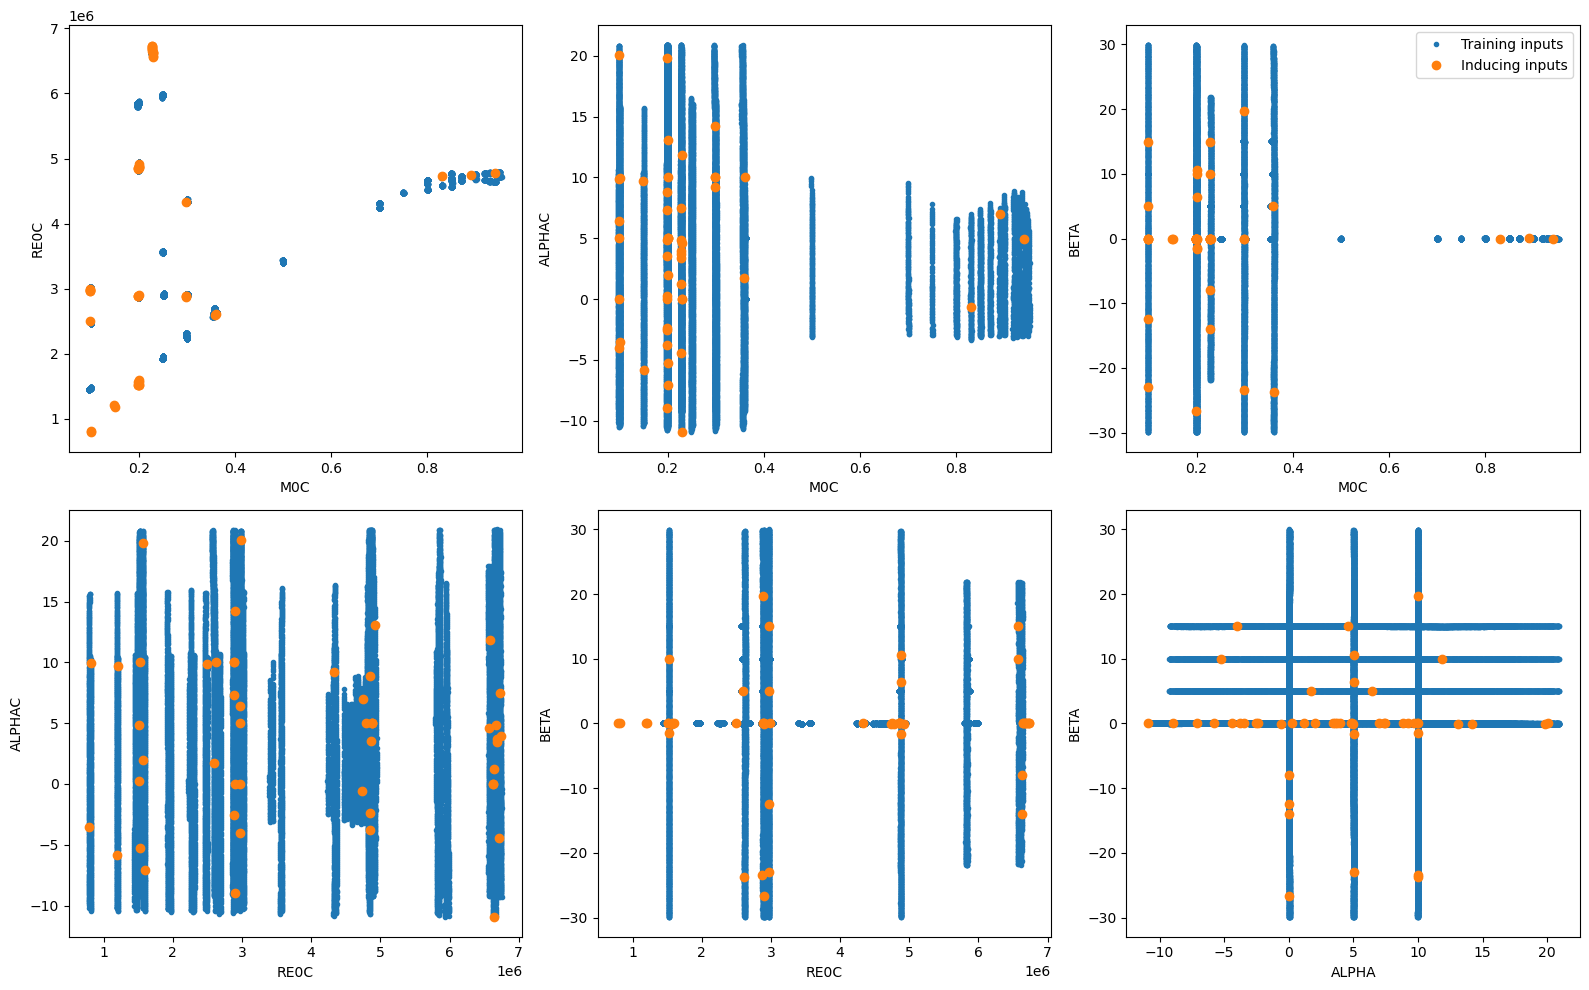

In [162]:
savename = "FIG_WT/CX_pairplot_M50_random.png"
pairplot_Z(X_train, Z1,savename)

#### 3. Train the SGP model

In [163]:
sm = SGP(method="VFE", theta0=theta, theta_bounds=bounds, print_prediction=False, n_start=1)
sm.set_training_values(X_train, CXC_train)
sm.set_inducing_inputs(Z=Z1)
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 47004
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 39.0147300


In [164]:
print("sigma2 :", sm.optimal_par["sigma2"])
print("theta  :", sm.optimal_theta)
print("noise  :", sm.optimal_noise)

sigma2 : 0.000573271768883524
theta  : [1.32908453e-01 2.42949511e-14 8.70368788e-03 1.23624416e-04]
noise  : 6.471515257501525e-05


#### 4. Prediction

In [165]:
Y_pred = sm.predict_values(X_test)
rmse = np.sqrt(np.mean((Y_pred.flatten() - CXC_test.flatten())**2))
print("RMSE = %2.4f" %rmse)

RMSE = 0.0085


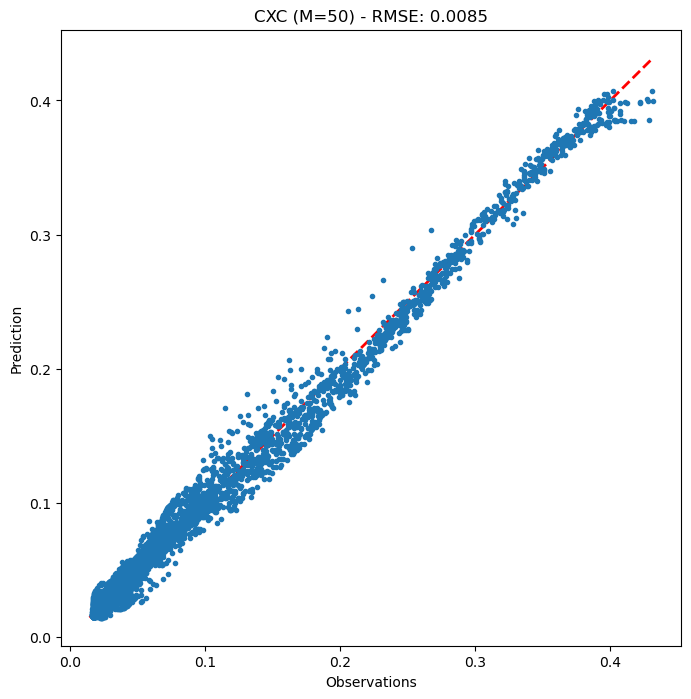

In [166]:
savename="FIG_WT/CXC_M50_random_VFE.png"
plot_res(Y_pred, CXC_test, "CXC", M, rmse, savename)

### A-2) Test with normalized k-means

Application of the k-means algorithm after data normalization since we have seen that the previous result was not very space-filling (cf. first k-means pairplots for ALPHA and BETA dimensions, section III-B2.). Then, reverse mapping of the inducing points to the initial input space.

In [167]:
min_vals = X_train.min(axis=0)
max_vals = X_train.max(axis=0)
X_train_normalized = (X_train - min_vals) / (max_vals - min_vals)

In [168]:
data = np.hstack((X_train_normalized, CXC_train))
Z_normalized = kmeans(data, M)[0][:,:-1]
Z3 = Z_normalized * (max_vals - min_vals) + min_vals

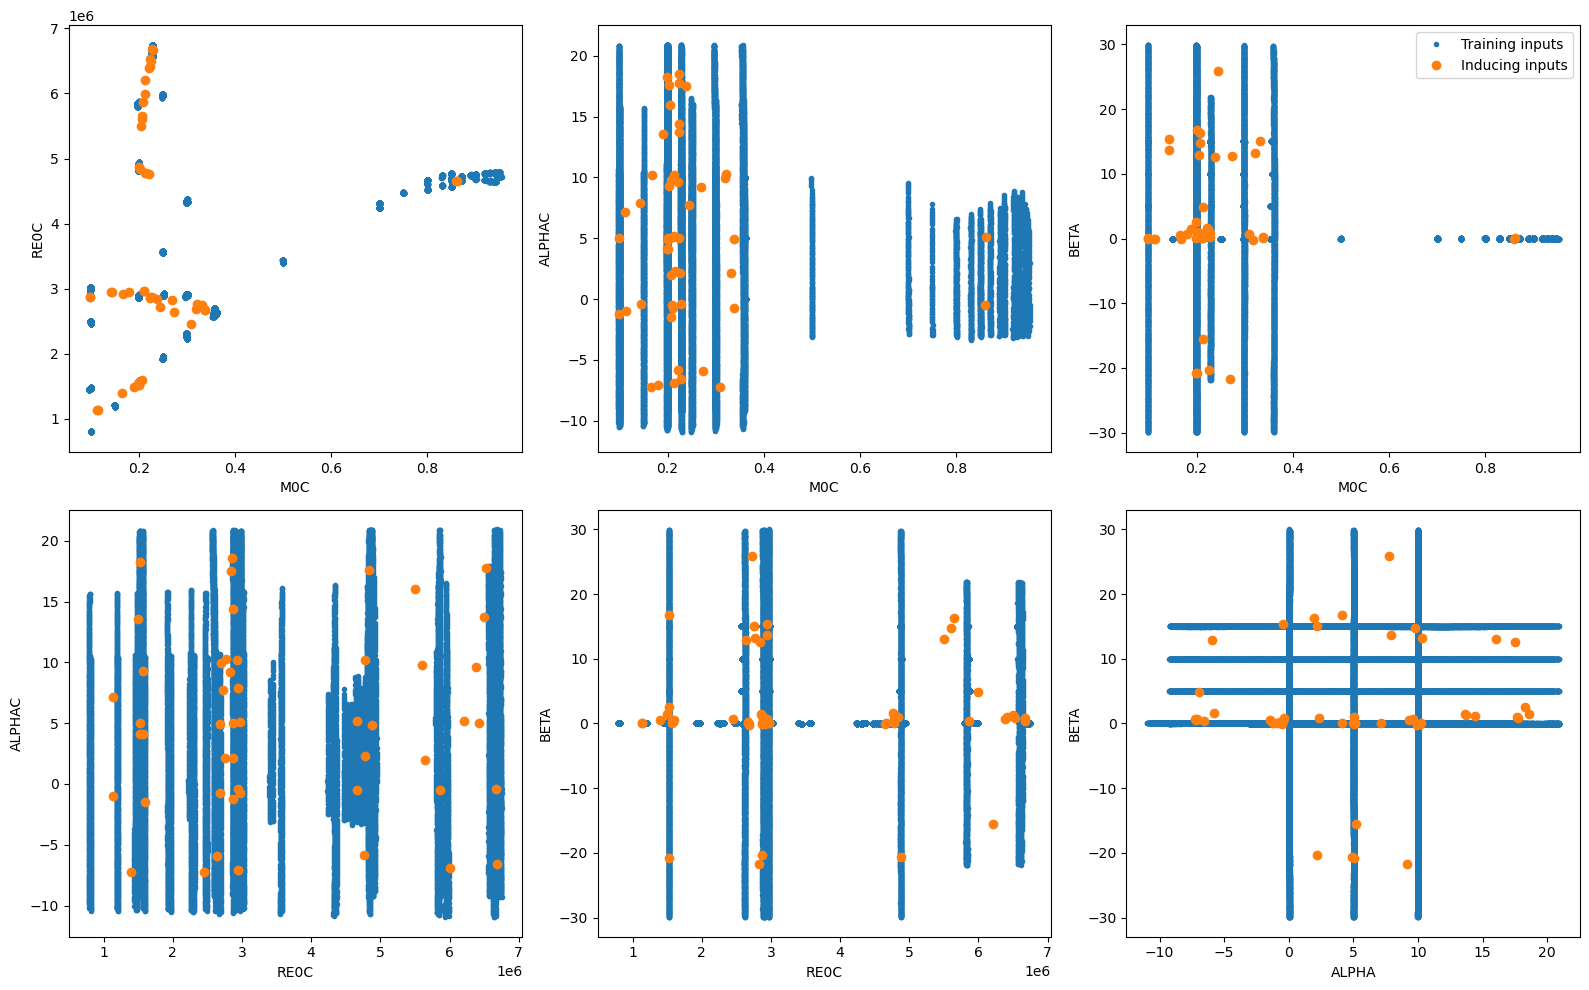

In [169]:
savename = "FIG_WT/CX_pairplot_M50_kmeansnorm.png"
pairplot_Z(X_train, Z3, savename)

In [170]:
sm = SGP(method="VFE", theta0=theta, theta_bounds=bounds, print_prediction=False, n_start=1)
sm.set_training_values(X_train, CXC_train)
sm.set_inducing_inputs(Z=Z3)
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 47004
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 39.1740468


In [171]:
Y_pred = sm.predict_values(X_test)
rmse = np.sqrt(np.mean((Y_pred.flatten() - CXC_test.flatten())**2))
print("RMSE = %2.4f" %rmse)

RMSE = 0.0088


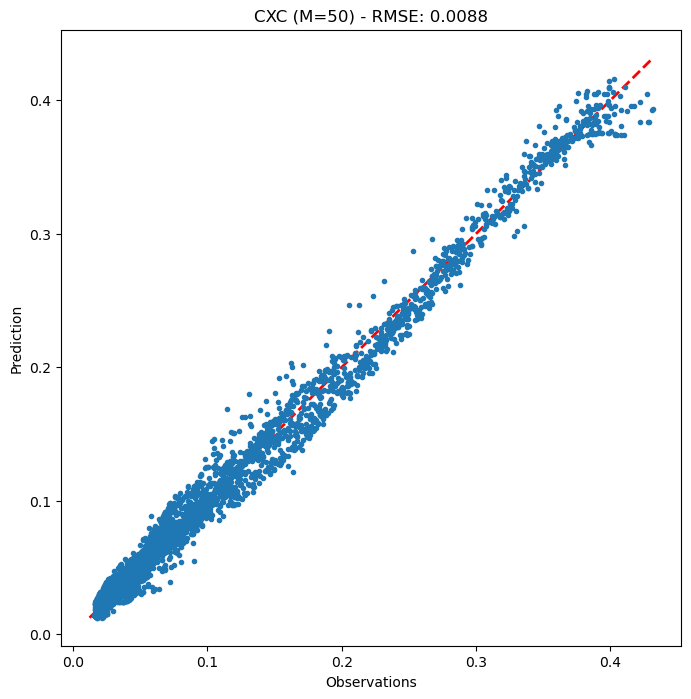

In [172]:
savename="FIG_WT/CXC_M50_kmeans_norm_VFE.png"
plot_res(Y_pred, CXC_test, "CXC", M, rmse, savename)

### A-3) Test with usual k-means

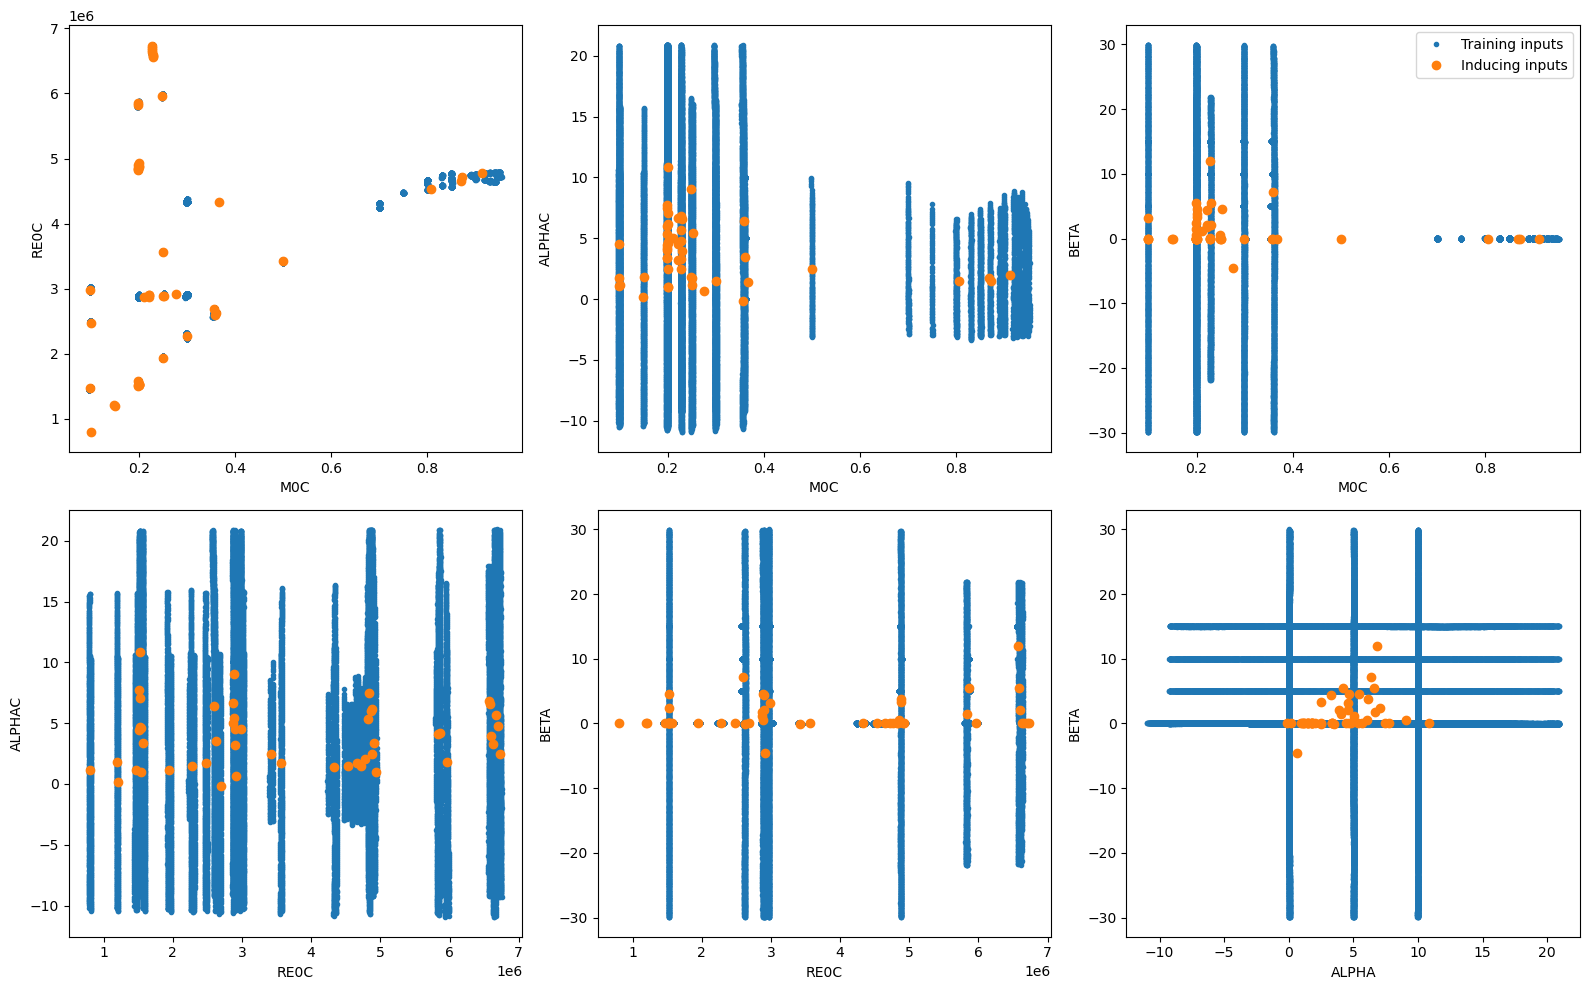

In [173]:
data = np.hstack((X_train, CXC_train))
Z2 = kmeans(data, M)[0][:,:-1]
savename = "FIG_WT/CX_pairplot_M50_kmeans.png"
pairplot_Z(X_train, Z2, savename)

In [174]:
sm = SGP(method="VFE", theta0=theta, theta_bounds=bounds, print_prediction=False, n_start=1)
sm.set_training_values(X_train, CXC_train)
sm.set_inducing_inputs(Z=Z2)
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 47004
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 38.9625111


In [175]:
Y_pred = sm.predict_values(X_test)
rmse = np.sqrt(np.mean((Y_pred.flatten() - CXC_test.flatten())**2))
print("RMSE = %2.4f" %rmse)

RMSE = 0.0090


In [176]:
#to compare the random, k-means and the normalized k-means

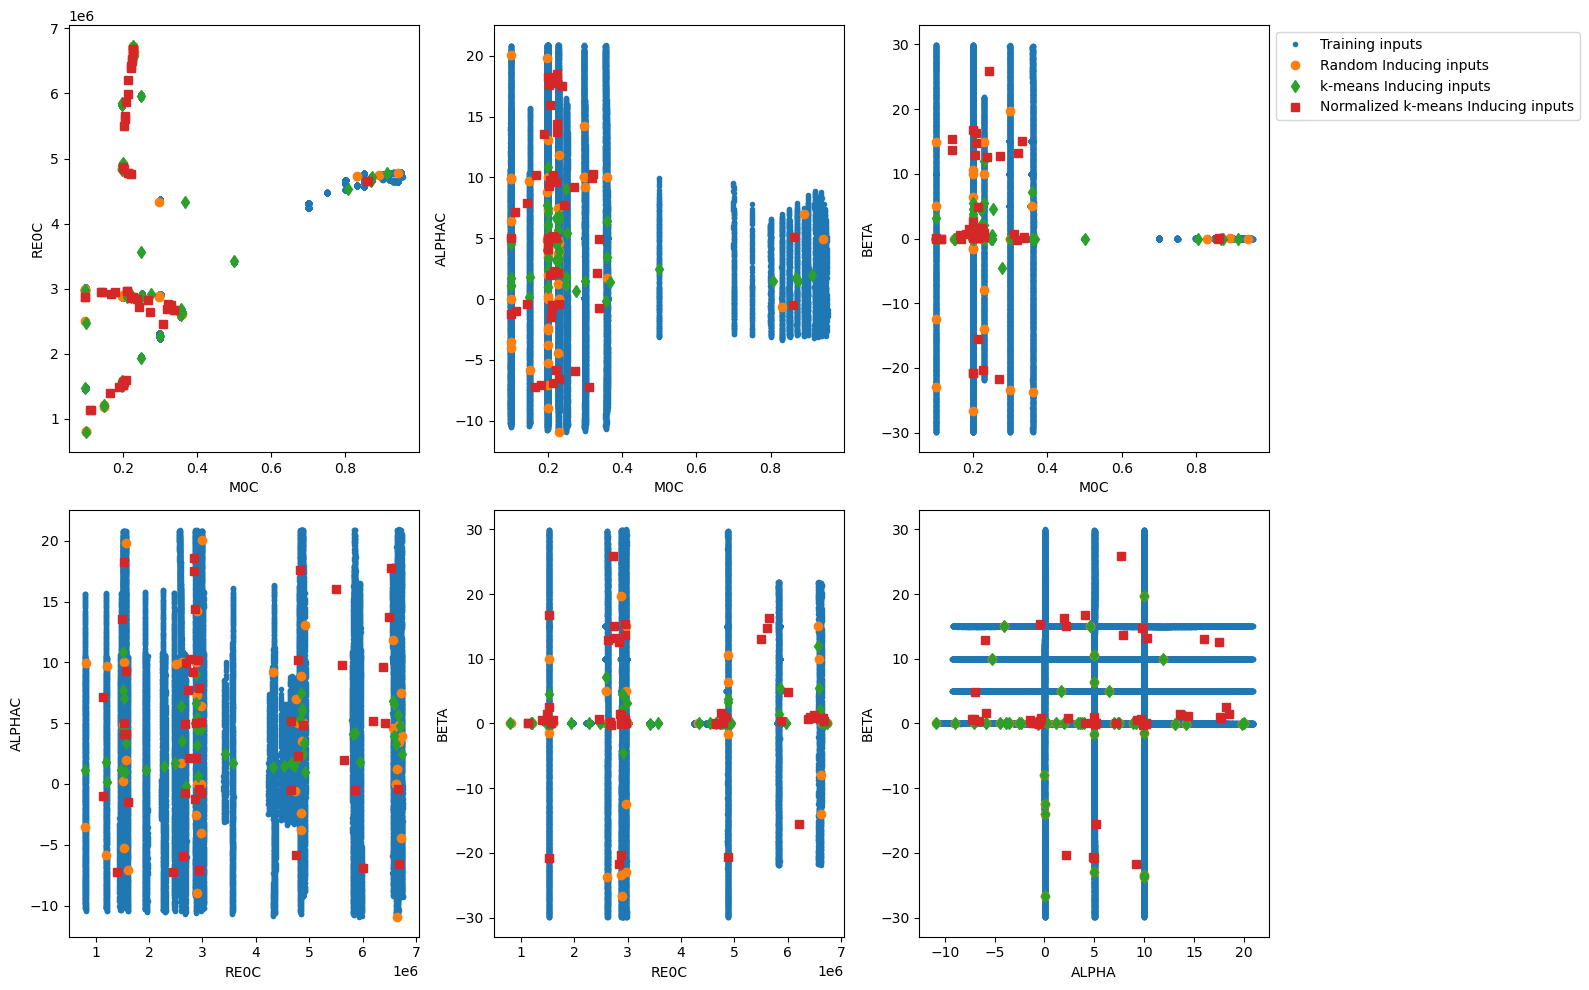

In [177]:
savename= "FIG_WT/CX_pairplot_M50_random_kmeans_kmeansnorm.png"
#Z1 random 
#Z2 kmeans
#Z3 kmeans normalized
pairplot_Z_all(X_train, Z1, Z2, Z3, savename)

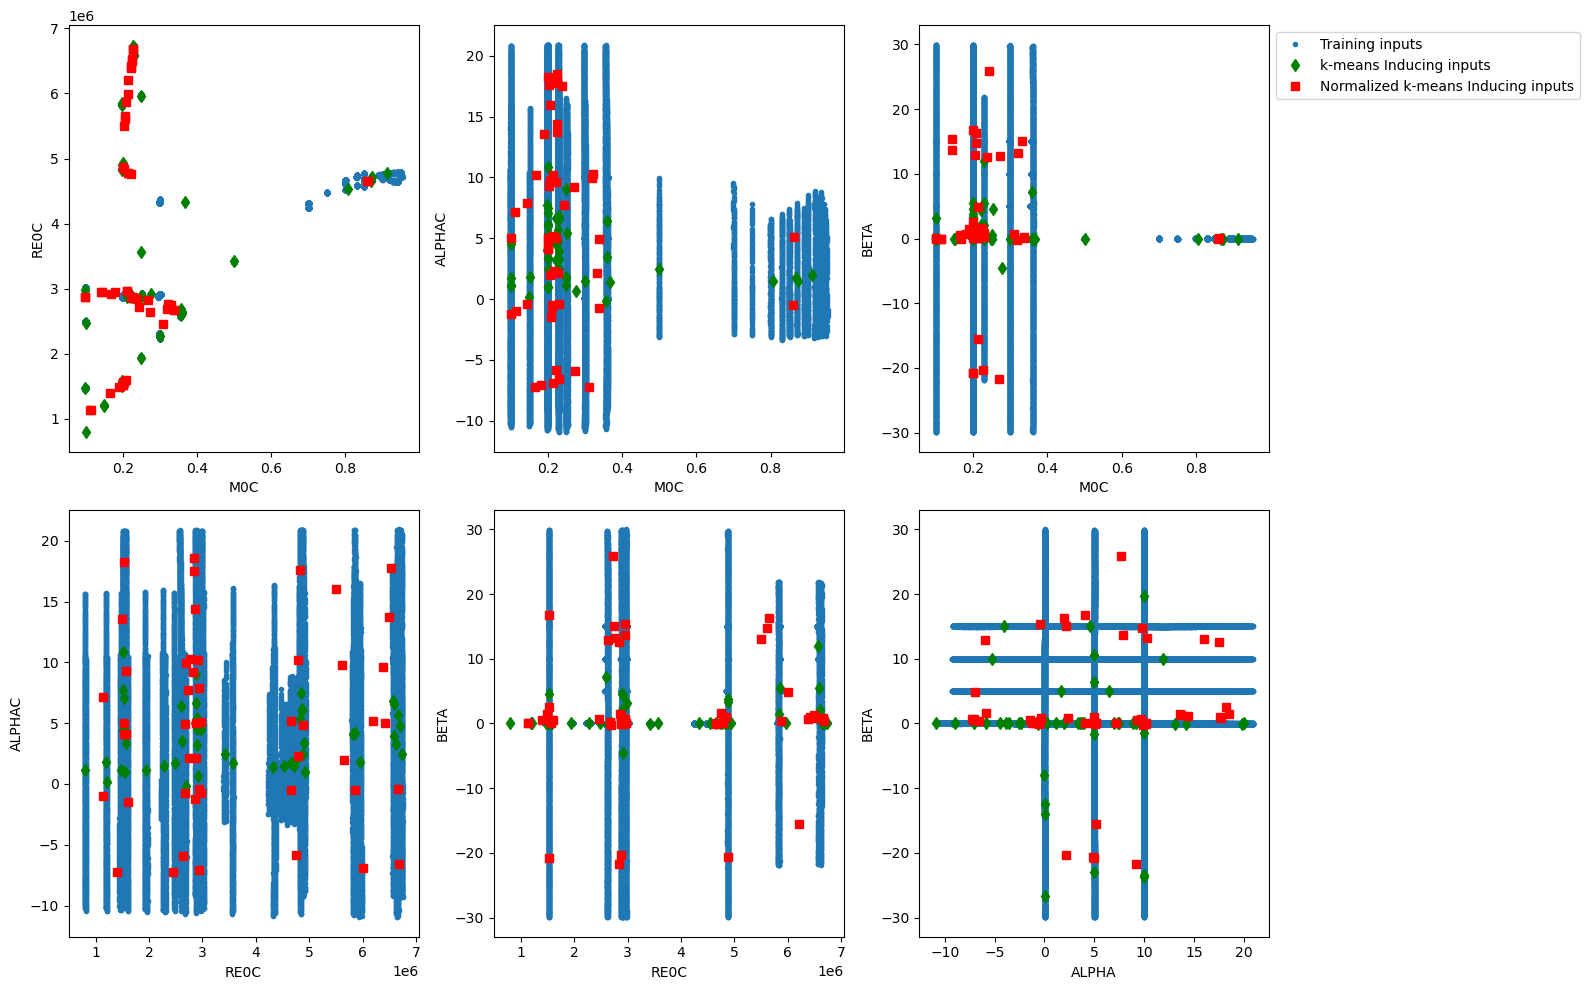

In [178]:
savename= "FIG_WT/CX_pairplot_M50_kmeans_kmeansnorm.png"
#Z2 kmeans
#Z3 kmeans normalized
pairplot_Z2_Z3(X_train, Z2, Z3, savename)

### B) CMAAC output

#### 1. Define train and test samples

In [179]:
print(' ------------------- Output  C_M ----------------------------------------')

 ------------------- Output  C_M ----------------------------------------


In [180]:
CMAAC = np.array(df[['CMAAC']])
CMAAC_train = CMAAC[random_idx]
CMAAC_test = np.delete(CMAAC, random_idx, axis=0)

#### 2. Define inducing inputs
Random permutations.

In [181]:
shuffle_idx = np.random.permutation(X_train.shape[0])[:M]
Z = X_train[shuffle_idx].copy()

#### 3. Train the SGP model

In [182]:
sm = SGP(method="VFE", theta0=theta, theta_bounds=bounds, print_prediction=False, n_start=1)
sm.set_training_values(X_train, CMAAC_train)
sm.set_inducing_inputs(Z=Z)
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 47004
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 39.5347278


In [183]:
print("sigma2 :", sm.optimal_par["sigma2"])
print("theta  :", sm.optimal_theta)
print("noise  :", sm.optimal_noise)
print("likelihood :", sm.optimal_rlf_value)

sigma2 : 0.0014942557175445933
theta  : [6.71760950e-02 2.25853687e-14 5.13814809e-03 1.56707121e-03]
noise  : 0.0005949964367595559
likelihood : [[150834.35825631]]


#### 4. Prediction

In [184]:
Y_pred = sm.predict_values(X_test)
rmse = np.sqrt(np.mean((Y_pred.flatten() - CMAAC_test.flatten())**2))
print("RMSE = %2.4f" %rmse)

RMSE = 0.0232


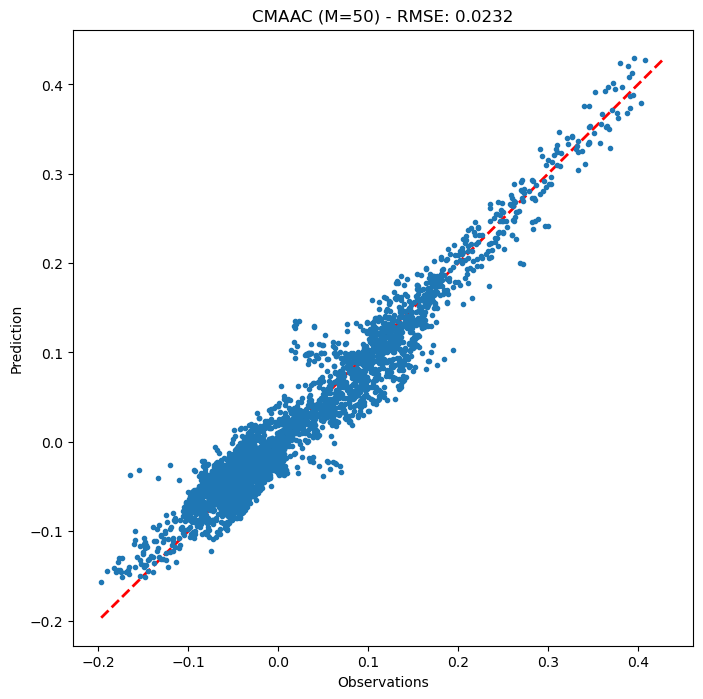

In [185]:
savename="FIG_WT/CXC_M50_random_VFE.png"
plot_res(Y_pred, CMAAC_test, "CMAAC", M, rmse, savename)

### Comparison with GPy
#### 1. FITC

In [186]:
if run_GPy:

    k = GPy.kern.RBF(input_dim=4, lengthscale=l0, ARD=True)
    sm = GPy.models.SparseGPRegression(X=X_train, Y=CMAAC_train, kernel=k, Z=Z)
    sm.inference_method = GPy.inference.latent_function_inference.FITC()
    sm.Z.fix()
    sm.optimize('simplex', messages=1, max_iters=200)

    Y_pred, _ = sm.predict(X_test)
    rmse = np.sqrt(np.mean((Y_pred.flatten() - CMAAC_test.flatten())**2))
    print("RMSE = %2.4f" %rmse)

#### 2. VFE

In [187]:
if run_GPy:

    k = GPy.kern.RBF(input_dim=4, lengthscale=l0, ARD=True)
    sm = GPy.models.SparseGPRegression(X=X_train, Y=CMAAC_train, kernel=k, Z=Z)
    sm.inference_method = GPy.inference.latent_function_inference.VarDTC()
    sm.Z.fix()
    sm.optimize('simplex', messages=1, max_iters=200)

    Y_pred, _ = sm.predict(X_test)
    rmse = np.sqrt(np.mean((Y_pred.flatten() - CMAAC_test.flatten())**2))
    print("RMSE = %2.4f" %rmse)

## VI - Errorbar plots
We here plot the predicted output of the previous model ('CMAAC') against the true output along with the predicted std (erorr bars).\
Only plot a few predictions of the test set for sake of visibility.

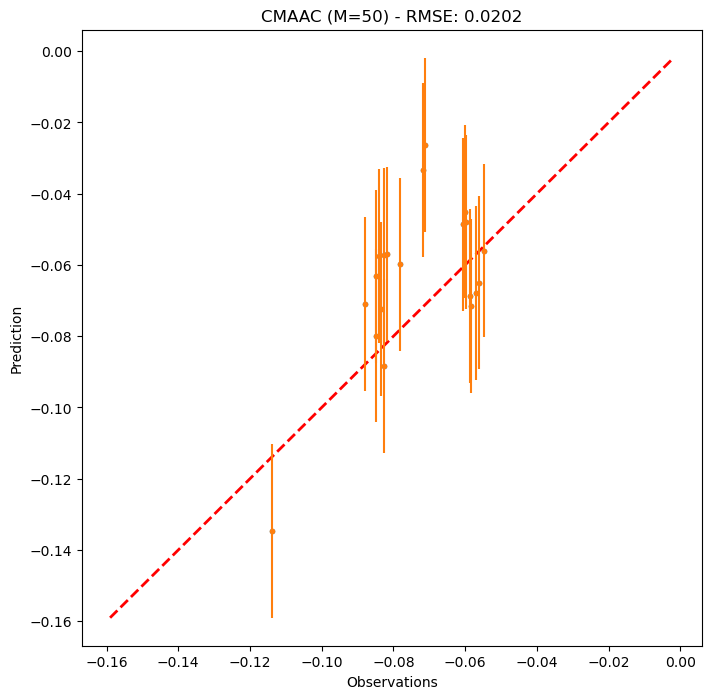

In [188]:
# predict and compute error
if run_GPy:
    Y_pred, Y_var = sm.predict(X_test[20:40,:])
else:
    Y_pred = sm.predict_values(X_test[20:40,:])
    Y_var = sm.predict_variances(X_test[20:40,:])
rmse = np.sqrt(np.mean((Y_pred.flatten() - CMAAC_test[20:40,:].flatten())**2))

# plot result
start = np.min([Y_pred, CMAAC_test[20:40,:]]) - np.max(np.sqrt(Y_var.flatten()))
end = np.max([Y_pred, CMAAC_test[20:40,:]]) + np.max(np.sqrt(Y_var.flatten()))
plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(CMAAC_test[20:40,:].flatten(), Y_pred.flatten(), '.')
plt.errorbar(CMAAC_test[20:40,:].flatten(), Y_pred.flatten(), yerr=np.sqrt(Y_var.flatten()), fmt='.')
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("CMAAC (M=%i) - RMSE: %.4f" %(M, rmse))
plt.savefig('FIG_WT/CM_true_predicted.png')
plt.show()

## VII- Comparison with full GP and SVGP

We recall that we have the following dimensions for the training set:

In [189]:
X_train.shape

(47004, 4)

As the standard GP model implies a memory cost of $\mathcal{O}(N^2)$ and an inference cost of $\mathcal{O}(N^3)$. This would lead us to the corresponding scales:

In [190]:
print("Memory cost: ~ %i values" %(X_train.shape[0]**2))
print("Considering float32, memory required: ~ %.2f Go" %(4*X_train.shape[0]**2/1024**3))
print("Considering float64, memory required: ~ %.2f Go" %(8*X_train.shape[0]**2/1024**3))
print(f"Inference cost: ~ {X_train.shape[0]**3:.2e} operations")

Memory cost: ~ 2209376016 values
Considering float32, memory required: ~ 8.23 Go
Considering float64, memory required: ~ 16.46 Go
Inference cost: ~ 1.04e+14 operations


Here, considering $M=100$ inducing points, the SGP model only implies a memory cost of $\mathcal{O}(NM)$ and an inference cost of $\mathcal{O}(NM^2)$.\
This would lead us to the corresponding scales:

In [191]:
print("Memory cost: ~ %i values" %(50*X_train.shape[0]))
print("Considering float32, memory required: ~ %.2f Mo" %(4*50*X_train.shape[0]/1024**2))
print("Considering float64, memory required: ~ %.2f Mo" %(8*50*X_train.shape[0]/1024**2))
print(f"Inference cost: ~ {X_train.shape[0]*50**2:.2e} operations")

Memory cost: ~ 2350200 values
Considering float32, memory required: ~ 8.97 Mo
Considering float64, memory required: ~ 17.93 Mo
Inference cost: ~ 1.18e+08 operations


And with SVGP, we could reduce even more the costs with the stochastic gradient optimization. With mini-batches of size $b=100$ we obtain:

In [192]:
print("Memory cost: ~ %i values" %(100*50+50**2))
print("Considering float32, memory required: ~ %.2f ko" %((100*50+50**2)/1024))
print("Considering float64, memory required: ~ %.2f ko" %((100*50+50**2)/1024))
print(f"Inference cost: ~ {(100*50**2+50**3):.2e} operations")

Memory cost: ~ 7500 values
Considering float32, memory required: ~ 7.32 ko
Considering float64, memory required: ~ 7.32 ko
Inference cost: ~ 3.75e+05 operations
